In [1]:
import sys
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import os
import itertools
import socket
from datetime import datetime
from pandas.tseries.offsets import DateOffset
import matplotlib.pyplot as plt
import time

import seaborn as sns
import matplotlib.pyplot as plt
from termcolor import colored
from IPython.display import display
from IPython.display import clear_output

C:\Users\zchodan\OneDrive - Franklin Templeton\Documents\Python\Kaggle\Playground Series\s5e1 - Sticker Sales


In [5]:
# Declare important variables
train_path = 'train.csv'
solve_path = 'test.csv'
target_variable = 'num_sold'
SEED = 69
skip_hypertuning = True
cat_encoder_type = 'OneHotEncoder' #OneHotEncoder, FrequencyEncoder, None

In [71]:
def load_dataframes(path1: str, path2: str, format1: str = "csv", format2: str = "csv") -> tuple:

    loaders = {
        "csv": pd.read_csv,
        "excel": pd.read_excel,
        "json": pd.read_json,
    }

    if format1 not in loaders or format2 not in loaders:
        raise ValueError("Unsupported format. Supported formats: 'csv', 'excel', 'json'.")

    # Load the dataframes using appropriate loaders
    df1 = loaders[format1](path1)
    df2 = loaders[format2](path2)

    print(f"Loading data from {os.getcwd()}")
    
    return df1, df2

In [125]:
df_train_original, df_solve_original = load_dataframes(train_path,solve_path)

Loading data from C:\Users\zchodan\OneDrive - Franklin Templeton\Documents\Python\Kaggle\Playground Series\s5e1 - Sticker Sales


In [127]:
df_train_id = df_train_original['id']
df_train = df_train_original.drop('id',axis=1)

df_solve_id = df_solve_original['id']
df_solve = df_solve_original.drop('id',axis=1)

In [129]:
from typing import Tuple

def plot_kde_grid(df: pd.DataFrame, n_cols: int = 4, figsize: Tuple[int, int] = (12,8)) -> None:
    """
    Plots KDE for all numeric columns in the dataframe in a grid layout.
    
    Parameters:
        df (pd.DataFrame): DataFrame with numeric columns to plot.
        n_cols (int): Number of columns in the grid (default is 3).
        figsize (tuple): Size of the entire figure (default is (12, 8)).
    
    Returns:
        None
    """
    # Get numeric columns
    numeric_cols = df.select_dtypes(include='number').columns
    
    # Set up grid size
    n_rows = int(np.ceil(len(numeric_cols) / n_cols))  # Number of rows based on the number of features
    
    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(figsize))  # Adjust figure size
    axes = axes.flatten()  # Flatten to easily iterate
    
    # Plot each numeric column
    for i, col in enumerate(numeric_cols):
        sns.kdeplot(data=df, x=col, fill=True, ax=axes[i])
        axes[i].set_title(f'Distribution of {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Density')
    
    # Hide any unused subplots
    for i in range(len(numeric_cols), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

In [41]:
#plot_kde_grid(df_train,n_cols=4,figsize=(12,8))

In [43]:
#plot_kde_grid(df_solve,n_cols=4,figsize=(9,6))

In [131]:
def describe_dataframe(df_to_use: pd.DataFrame, name: str = 'DataFrame', nrows: int = 3, plots: bool = False, info: bool = True) -> None:
    '''
    Function to describe the DataFrame with summary statistics, missing value count,
    unique value count, and duplicate count. It also displays plots for missing and unique values.
    
    Parameters:
    - df: The DataFrame to describe.
    - name: The name to display in the summary (default is 'DataFrame').
    - nrows: The number of rows to display from the top and bottom (default is 3).
    - plots: Whether to display bar plots for missing and unique values (default is False).
    - info: Whether to display the styled DataFrame (default is True).
    '''

    df = df_to_use.copy()
    
    # Create summary DataFrame
    inf = pd.DataFrame(df.dtypes).reset_index().rename(columns={'index':'column', 0:'type'})
    
    # Missing values
    df_missing = pd.DataFrame(df.isnull().sum()).reset_index().rename(columns={'index':'column', 0:'missing'})
    df_missing['pct_missing'] = (df_missing['missing'] / df.shape[0]) * 100
    
    # Unique values
    df_unique = pd.DataFrame(df.nunique()).reset_index().rename(columns={'index':'column', 0:'unique'})
    
    # Combine summary information
    inf['missing'] = df_missing['missing']
    inf['pct_missing'] = df_missing['pct_missing']
    inf['unique'] = df_unique['unique']
    inf['duplicate'] = df.duplicated().sum()
    inf['count'] = df.shape[0]

    # Descriptive statistics
    desc = pd.DataFrame(df.describe(include='all').transpose())
    if 'min' in desc.columns.tolist():
        inf['min'] = desc['min'].values
        inf['max'] = desc['max'].values
        inf['avg'] = desc['mean'].values
        inf['std dev'] = desc['std'].values
    if 'top' in desc.columns.tolist():
        inf['top value'] = desc['top'].values
        inf['Freq'] = desc['freq'].values 
    
    # Display styled DataFrame
    if info:
        display(inf.style.background_gradient(subset=['missing','pct_missing'], cmap='Reds').background_gradient(subset='unique', cmap='Greens'))

    if nrows != 0 :
        # Display top and bottom nrows of the DataFrame
        print(f"\n---------- {name} Overview ----------:")
        print(f"{name} has {df.shape[0]} rows and {df.shape[1]} columns\n")
        display(df.head(nrows))
        display(df.tail(nrows))
    
    # Plot missing values if any
    if plots and df_missing['missing'].sum() > 0:
        fig, ax = plt.subplots(1, 1, figsize=(24, 5))
        sns.barplot(df_missing[df_missing['missing'] > 0], x='column', y='missing', ax=ax)
        ax.set_title(f'{name} missing Values') 
        ax.bar_label(ax.containers[0])
        plt.tight_layout()
        plt.show()
    
        # Plot unique values
        fig, ax = plt.subplots(1, 1, figsize=(24, 5))
        sns.barplot(df_unique[df_unique['unique'] > 0], x='column', y='unique', ax=ax)
        ax.set_title(f'{name} Unique Values')
        ax.bar_label(ax.containers[0])
        plt.tight_layout()
        plt.show()

In [133]:
def get_num_cols(df: pd.DataFrame):
    num_cols = df.select_dtypes(include=['number']).columns.to_list()
    
    return num_cols

In [137]:
def get_cat_cols(df: pd.DataFrame):
    cat_cols = df.select_dtypes(include=['object', 'string', 'category']).columns.tolist()  

    return cat_cols

In [161]:
def clean_dataframe(df_to_use: pd.DataFrame, impute_num_nulls: bool = True, fill_cat_nulls: bool = True) -> None:
    df = df_to_use.copy()
    
    # Filter columns where the type is either 'float' or 'int' and there are missing values
    numeric_cols = df.select_dtypes(include=['number']).columns
    missing_numeric_columns = [
        col for col in numeric_cols if df[col].isnull().sum() > 0
    ]

    # Target field 'num_sold' is missing some values, we do not want to impute them
    if 'num_sold' in missing_numeric_columns:
        missing_numeric_columns.remove('num_sold')
    
    # Fill nulls in numeric columns with the median
    if impute_num_nulls:       
        for column in missing_numeric_columns:
            mdn = df[column].median()
            df[column] = df[column].fillna(mdn)

    
    # Get category columns
    if fill_cat_nulls:
        cat_cols = df.select_dtypes(include=['object', 'string','category']).columns.tolist()  
        # Fill missing values in object columns
        for column in cat_cols:
            df[column] = df[column].fillna('Unknown')
    
    return df

In [191]:
def transform_dataframe(df_to_use: pd.DataFrame) -> None:
    
    df = df_to_use.copy()

    if 'num_sold' in df.columns:
        df = df.dropna(subset=['num_sold'])
    
    return df

In [482]:
# Clean and Transform Data

In [193]:
df_train_cleaned = clean_dataframe(df_train, impute_num_nulls = True, fill_cat_nulls=False)
df_solve_cleaned = clean_dataframe(df_solve, impute_num_nulls = True, fill_cat_nulls=False)

In [195]:
df_train_prepared = transform_dataframe(df_train_cleaned)
df_solve_prepared = transform_dataframe(df_solve_cleaned)

In [485]:
# Inspect Data through phases of clean and transform

In [197]:
describe_dataframe(df_train, name='Insurance Data', nrows=0, plots=False, info=True)

,column,type,missing,pct_missing,unique,duplicate,count,min,max,avg,std dev,top value,Freq
0,date,object,0,0.000000,2557,0,230130,nan,nan,nan,nan,2010-01-01,90
1,country,object,0,0.000000,6,0,230130,nan,nan,nan,nan,Canada,38355
2,store,object,0,0.000000,3,0,230130,nan,nan,nan,nan,Discount Stickers,76710
3,product,object,0,0.000000,5,0,230130,nan,nan,nan,nan,Holographic Goose,46026
4,num_sold,float64,8871,3.854778,4037,0,230130,5.000000,5939.000000,752.527382,690.165445,nan,nan


In [199]:
describe_dataframe(df_train_cleaned, name='Insurance Data', nrows=0, plots=False, info=True)

,column,type,missing,pct_missing,unique,duplicate,count,min,max,avg,std dev,top value,Freq
0,date,object,0,0.000000,2557,0,230130,nan,nan,nan,nan,2010-01-01,90
1,country,object,0,0.000000,6,0,230130,nan,nan,nan,nan,Canada,38355
2,store,object,0,0.000000,3,0,230130,nan,nan,nan,nan,Discount Stickers,76710
3,product,object,0,0.000000,5,0,230130,nan,nan,nan,nan,Holographic Goose,46026
4,num_sold,float64,8871,3.854778,4037,0,230130,5.000000,5939.000000,752.527382,690.165445,nan,nan


In [201]:
describe_dataframe(df_train_prepared, name='Insurance Data', nrows=0, plots=False, info=True)

,column,type,missing,pct_missing,unique,duplicate,count,min,max,avg,std dev,top value,Freq
0,date,object,0,0.000000,2557,0,221259,nan,nan,nan,nan,2010-01-01,88
1,country,object,0,0.000000,6,0,221259,nan,nan,nan,nan,Finland,38355
2,store,object,0,0.000000,3,0,221259,nan,nan,nan,nan,Premium Sticker Mart,75684
3,product,object,0,0.000000,5,0,221259,nan,nan,nan,nan,Kaggle,46026
4,num_sold,float64,0,0.000000,4037,0,221259,5.000000,5939.000000,752.527382,690.165445,nan,nan


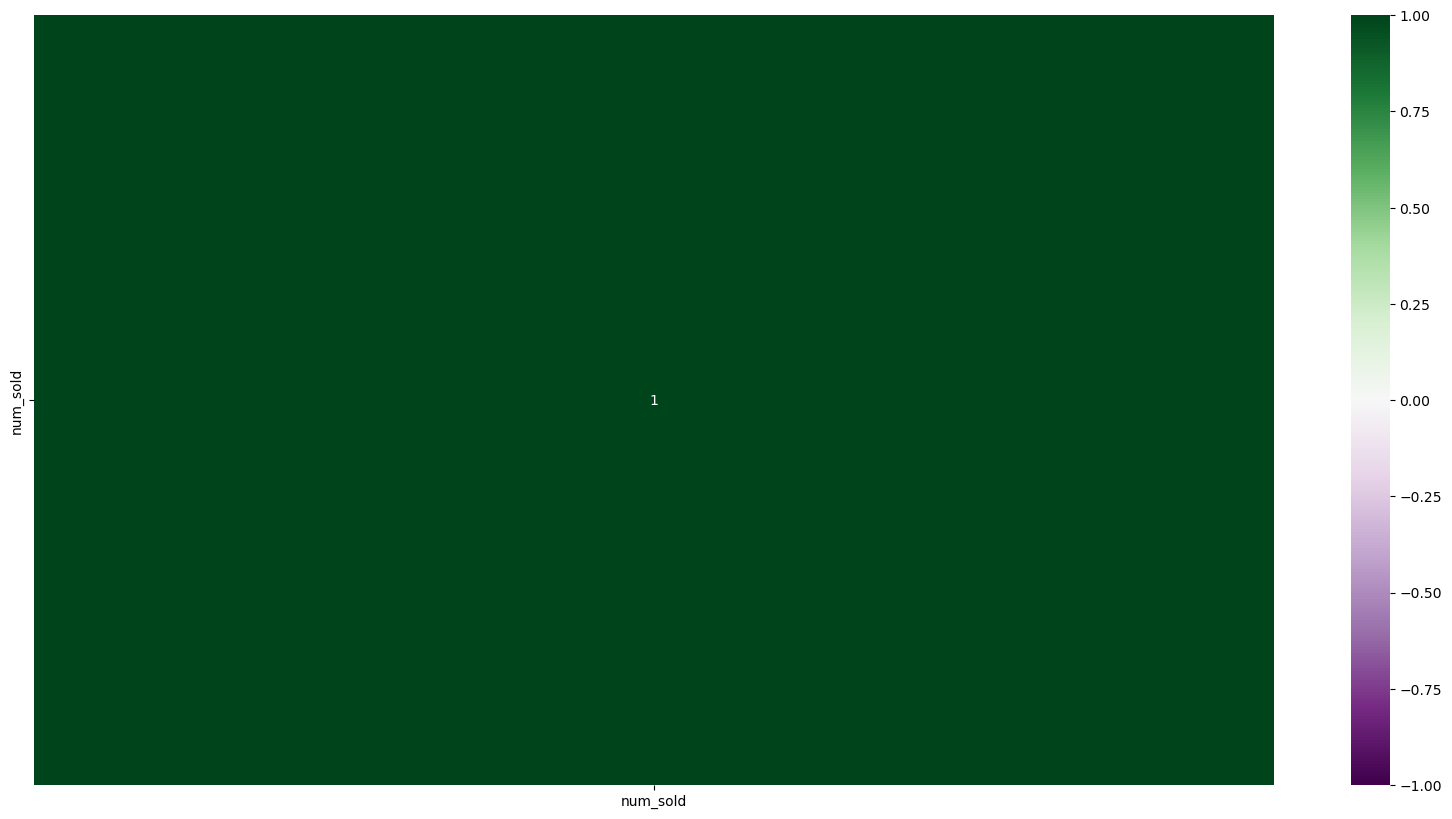

In [203]:

num_cols = get_num_cols(df_train_prepared)

plt.figure(figsize=(20,10))
sns.heatmap(df_train_prepared[num_cols].corr(),
            vmin=-1,
            vmax=1,
            center=0,
            annot=True,
            cmap='PRGn')
plt.show()

In [490]:
from sklearn.model_selection import train_test_split

# Split into 80% training data and 20% testing data

X = df_train_prepared.drop('Premium Amount', axis=1)
y = df_train_prepared['Premium Amount'].copy()

# Define test size and validation size relative to the entire dataset
test_size = 0.2
val_size = 0.2 / (1 - test_size)  # Validation size relative to training data

# Create train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=SEED)

# Create train/val split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size, random_state=SEED)

# y target has a right skew distribution so we log it 
y_log_train = np.log1p(y_train)
y_log_val = np.log1p(y_val)
y_log_test = np.log1p(y_test)

In [491]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd

def pipeline_fit(train_df: pd.DataFrame, cat_encoder: str = 'None'):
    
    # Define a custom transformer for frequency encoding
    class FrequencyEncoder(BaseEstimator, TransformerMixin):
        def __init__(self, columns):
            self.columns = columns

        def fit(self, X, y=None):
            # Calculate the frequency for each category in the columns
            self.freq_dict = {}
            for col in self.columns:
                # Percentage-Based frequency
                self.freq_dict[col] = X[col].value_counts() / len(X)
            return self

        def transform(self, X):
            X_copy = X.copy()
            # Apply frequency encoding based on training set frequencies
            for col in self.columns:
                X_copy[col] = X_copy[col].map(self.freq_dict[col]).fillna(0)
            return X_copy

    # Identify numeric and categorical columns
    num_cols = get_num_cols(train_df)
    cat_cols = get_cat_cols(train_df)

    # Define a ColumnTransformer based on the specified encoding type
    if cat_encoder == 'OneHotEncoder':
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), num_cols),
                ('cat', OneHotEncoder(), cat_cols)
            ],
            remainder='passthrough'
        )
    elif cat_encoder == 'FrequencyEncoder':
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), num_cols),
                ('cat', FrequencyEncoder(columns=cat_cols), cat_cols)
            ],
            remainder='passthrough'
        )
    elif cat_encoder == 'None':
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), num_cols),
            ],
            remainder='passthrough'
        )
    else:
        raise ValueError("cat_encoder must be 'OneHotEncoder', 'FrequencyEncoder', or 'None'.")

    # Create a pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor)
    ])

    # Fit and transform the train data
    X_train_prepared = pipeline.fit_transform(train_df)

    # Extract column names for the transformed DataFrame
    if cat_encoder == 'OneHotEncoder':
        num_feature_names = num_cols  # Numeric features retain their original names
        cat_feature_names = pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(cat_cols)
        transformed_columns = list(num_feature_names) + list(cat_feature_names)
    elif cat_encoder == 'FrequencyEncoder' or cat_encoder == 'None':
        transformed_columns = num_cols + cat_cols

    # Convert the output to a DataFrame (All columns are OBJECT)
    X_train_prepared_df = pd.DataFrame(X_train_prepared, columns=transformed_columns)

    return X_train_prepared, X_train_prepared_df, pipeline


def pipeline_transform(test_df: pd.DataFrame, pipeline: Pipeline, cat_encoder: str = 'None'):
    # Transform the test data using the provided pipeline
    X_test_transformed = pipeline.transform(test_df)

    # Extract column names for the transformed DataFrame
    num_cols = get_num_cols(test_df)
    cat_cols = get_cat_cols(test_df)

    if cat_encoder == 'OneHotEncoder':
        num_feature_names = num_cols  # Numeric features retain their original names
        cat_feature_names = pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(cat_cols)
        transformed_columns = list(num_feature_names) + list(cat_feature_names)
    elif cat_encoder == 'FrequencyEncoder' or cat_encoder == 'None':
        transformed_columns = num_cols + cat_cols

    # Convert the output to a DataFrame (All columns are OBJECT)
    X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=transformed_columns)

    return X_test_transformed, X_test_transformed_df




In [492]:
# Fit the Pipeline
X_train_prepared, X_train_prepared_df, pipeline = pipeline_fit(X_train, cat_encoder = cat_encoder_type)
# Transform using the Pipeline
X_val_prepared, X_val_prepared_df = pipeline_transform(X_val, pipeline, cat_encoder = cat_encoder_type)
X_test_prepared, X_test_prepared_df = pipeline_transform(X_test, pipeline, cat_encoder = cat_encoder_type)

In [493]:
from tensorflow import keras
from tensorflow.keras import backend as K

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [494]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

# Parameter grid
param_grid = {
    'max_depth': [6, 10],        # limit on depth
    'learning_rate': [0.01,.001], # Step size for updates
    'n_estimators': [750, 1200], # Number of boosting rounds
}

# Leave some cores available
available_cores = os.cpu_count()
n_cores = max(1, available_cores - 3)  # Leave 3 cores free


xgb = XGBRegressor(random_state=SEED)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",  # Use RMSE as the evaluation metric
    cv=5,  # #-fold cross-validation
    verbose=2,  # Output progress messages
    n_jobs=n_cores  # Use all available cores
)

if skip_hypertuning:

    best_params = {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 1200}

else:
    start_time = time.time()
    
    grid_search.fit(X_train_prepared, y_log_train)
    
    end_time = time.time()  
    
    best_params = grid_search.best_params_
    best_rmse = (-grid_search.best_score_) ** 0.5
    
    print("Best parameters:",best_params)
    print("Best RMSE:", best_rmse)

    # Calculate elapsed time in minutes
    elapsed_time_minutes = (end_time - start_time) / 60
    print(f"Elapsed time: {elapsed_time_minutes:.2f} minutes")

In [ ]:
#####
# Try Bayesian Optimization
#### 
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

# Hyperparameters for BayesSearchCV tuning
search_spaces = {
    'n_estimators': (10, 200),      
    'max_depth': (3, 10),            
    'reg_alpha': (0.001, 0.2, 'log-uniform'),  
    'reg_lambda': (0.1, 100, 'log-uniform')     
}

# Leave some cores available
available_cores = os.cpu_count()
n_cores = max(1, available_cores - 3)  # Leave 3 cores free


xgb = XGBRegressor(random_state=SEED)

# Set up BayesSearchCV for hyperparameter tuning
search = BayesSearchCV(
    estimator=model,
    search_spaces=search_spaces,
    n_iter=50,          # Number of iterations for optimization
    cv=5,               # k-fold cross-validation
    verbose=1,          # Display detailed logs
    scoring="neg_root_mean_squared_error",
    random_state=42     
)

if skip_hypertuning:

    best_params = {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 1200}

else:
    start_time = time.time()
    
    grid_search.fit(X_train_prepared, y_log_train)
    
    end_time = time.time()  
    
    best_params = grid_search.best_params_
    best_rmse = (-grid_search.best_score_) ** 0.5
    
    print("Best parameters:",best_params)
    print("Best RMSE:", best_rmse)

    # Calculate elapsed time in minutes
    elapsed_time_minutes = (end_time - start_time) / 60
    print(f"Elapsed time: {elapsed_time_minutes:.2f} minutes")

In [495]:

# Initialize the XGBRegressor
model = XGBRegressor(
    **best_params,
    random_state=SEED        # Ensure reproducibility
)

# Train the model
model.fit(
    X_train_prepared, 
    y_log_train, 
    eval_set=[(X_val_prepared, y_log_val)],
    verbose=0
)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1200, n_jobs=None,
             num_parallel_tree=None, random_state=69, ...)

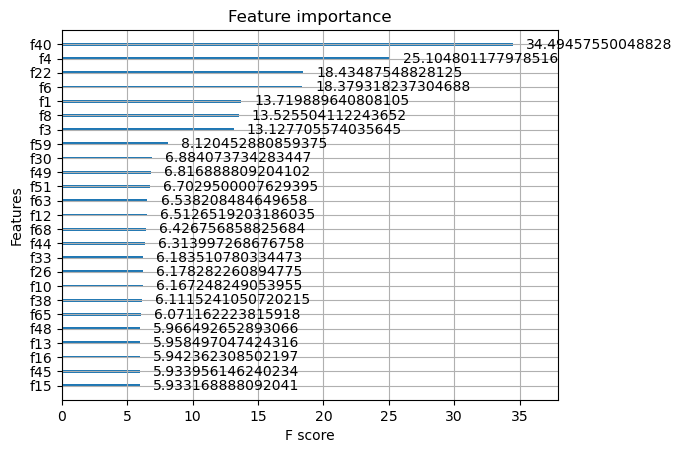

In [496]:
from xgboost import plot_importance

#Plot feature importance
plot_importance(model, importance_type='gain', max_num_features=min(X_train_prepared.shape[1], 25))  
# 'weight', 'gain', 'cover' are possible importance types
plt.show()

In [497]:
# Predict on test set
y_test_pred = model.predict(X_test_prepared)

In [498]:
from sklearn.metrics import root_mean_squared_error

# Calculate RMSE
rmse = root_mean_squared_error(y_log_test, y_test_pred)
print(f"RMSE: {rmse:.5f}")

RMSE: 1.05597


In [499]:
# Work Dataset
# RMSE: 1.05554 (FrequencyEncoder)
# RMSE: 1.05597 (OneHotEncoder)

In [500]:
# Home Dataset
# RMSE: 1.04541 (FrequencyEncoder)
# RMSE: 1.04536 (OneHot Encode): Submit Result = 1.0567

<Axes: >

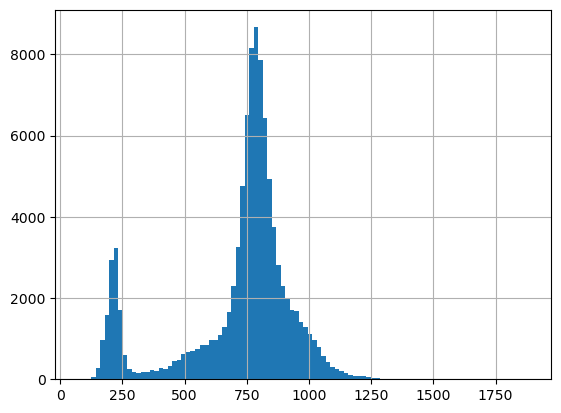

In [501]:
# Create final predictions
df_solve_cleaned = clean_dataframe(df_solve, impute_num_nulls = True, fill_cat_nulls=False)
df_solve_prepared = transform_dataframe(df_solve_cleaned)
X_solve_prepared, X_solve_prepared_df = pipeline_transform(df_solve_prepared, pipeline, cat_encoder = cat_encoder_type)


y_log_solve = model.predict(X_solve_prepared)

y_solve = np.expm1(y_log_solve)  # Inverse of log1p (to get the original scale)

df_y_solve = pd.DataFrame(y_solve, columns=['Premium Amount'])
df_final = pd.merge(df_solve_id, df_y_solve, left_index=True, right_index=True, how='inner')
df_final.to_csv('Predictions_XGBoost.csv', index=False)

df_final['Premium Amount'].hist(bins=100)